In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import joblib
import seaborn as sns
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as 
from Utilities.ipython_exit import exit

print ('Success')


Welcome to JupyROOT 6.24/06
Success


## Reading in files

In [2]:
Params = {"Run":"run1", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":10,
          "Load_standard":True,
          "Load_DetVars":False,
          "Only_keep_common_DetVar_evs":True,
          "Load_data":False,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "EXT_in_training":False,
          "Load_pi0_signal":False} 

feature_names = Variables.First_pass_vars_for_BDT #All variables
feature_names_MC = feature_names + ["weight"]
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/my_vars/"

In [3]:
signal_samples_dict = {}

if Params["Load_pi0_signal"] == False:
    Presel_overlay = pd.read_pickle(loc_pkls+"Preselected_overlay_"+Params["Run"]+"_my_vars_flattened_final.pkl")
    if Params["Load_single_file"] == True:
        HNL_mass = Params["single_file"]
        Presel_signal = pd.read_pickle(loc_pkls+f"Preselected_{HNL_mass}_"+Params["Run"]+"_my_vars_flattened_final.pkl")
        signal_samples_dict[HNL_mass] = Presel_signal
    else:
        for HNL_mass in Constants.HNL_mass_samples:
            Presel_signal = pd.read_pickle(loc_pkls+f"Preselected_{HNL_mass}_"+Params["Run"]+"_my_vars_flattened_final.pkl")
            signal_samples_dict[HNL_mass] = Presel_signal
    
if Params["Load_pi0_signal"] == True:
    Presel_overlay = pd.read_pickle(loc_pkls+"pi0_selection/Preselected_"+Params["Run"]+"_overlay_final.pkl")
    
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        Presel_signal = pd.read_pickle(loc_pkls+f"pi0_selection/Preselected_"+Params["Run"]+f"_{HNL_mass}_pi0_final.pkl")
        signal_samples_dict[HNL_mass] = Presel_signal
    
if Params["EXT_in_training"] == True:
    Presel_EXT = pd.read_pickle(loc_pkls+"Preselected_EXT_"+Params["Run"]+"_my_vars_flattened_final.pkl")
    

## Splitting into test and training samples

In [4]:
New_feature_list = ['shrclusdir2', 'n_tracks', 'trk_energy', 'shr_theta_v', 'contained_sps_ratio', 'trk_chipr_best', 'shr_px_v',
                    'trk_end_x_v', 'n_pfps', 'pfnplanehits_V', 'pfnplanehits_U', 'trk_calo_energy_u_v', 'nu_flashmatch_score', 'trk_score_v',
                    'NeutrinoEnergy2', 'shr_phi_v', 'pfnplanehits_Y', 'shr_pz_v', 'trk_theta_v', 'trk_phi_v', 'trk_energy_hits_tot',
                    'trk_dir_z_v', 'SliceCaloEnergy2']
print(f"Number of features is {len(New_feature_list)}")
# bdt_vars = feature_names
bdt_vars = New_feature_list #This is using just the most important variables list

new_value = -9999 #This tells XGB what number refers to missing data for all variables

signal_train_dict = {}
signal_test_dict = {}
labels_dict = {} 

train_vs_test_fraction = 0.7 #This is the fraction used for training

print(f"Total length of overlay file is {len(Presel_overlay)}")

overlay_train = Presel_overlay[:int(len(Presel_overlay)*train_vs_test_fraction)]
overlay_test = Presel_overlay[int(len(Presel_overlay)*train_vs_test_fraction):]

print(f"Total length of overlay TRAIN file is {len(overlay_train)}")
print(f"Total length of overlay TEST file is {len(overlay_test)}")

# overlay_train = Presel_overlay[int(len(Presel_overlay)*train_vs_test_fraction):] #OLD WRONG WAY, i.e 70% test
# overlay_test = Presel_overlay[:int(len(Presel_overlay)*train_vs_test_fraction)]

Number of features is 23
Total length of overlay file is 48233
Total length of overlay TRAIN file is 33763
Total length of overlay TEST file is 14470


In [6]:
pickle_files = False

if Params["Load_pi0_signal"] == False:
    overlay_test.to_pickle(loc_pkls+"BDT_Test_dfs/Test_overlay_"+Params["Run"]+"_my_vars_flattened_FIXED.pkl")
    
    for HNL_mass in signal_samples_dict:
        signal_train_dict[HNL_mass] = signal_samples_dict[HNL_mass][:int(len(signal_samples_dict[HNL_mass])*train_vs_test_fraction)]
        signal_test_dict[HNL_mass] = signal_samples_dict[HNL_mass][int(len(signal_samples_dict[HNL_mass])*train_vs_test_fraction):]
        if pickle_files == True:
            print(f"Pickling {HNL_mass}MeV HNL test sample")
            signal_test_dict[HNL_mass].to_pickle(loc_pkls+f"BDT_Test_dfs/Test_signal_{HNL_mass}_"+Params["Run"]+"_my_vars_flattened_FIXED.pkl")
    
        labels_dict[HNL_mass] = [1]*len(signal_train_dict[HNL_mass][bdt_vars]) + [0]*len(overlay_train[bdt_vars])
if Params["Load_pi0_signal"] == True:
    overlay_test.to_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_overlay_"+Params["Run"]+"_FIXED.pkl")

    for HNL_mass in signal_samples_dict:
        signal_train_dict[HNL_mass] = signal_samples_dict[HNL_mass][:int(len(signal_samples_dict[HNL_mass])*train_vs_test_fraction)]
        signal_test_dict[HNL_mass] = signal_samples_dict[HNL_mass][int(len(signal_samples_dict[HNL_mass])*train_vs_test_fraction):]
        if pickle_files == True:
            print(f"Pickling {HNL_mass}MeV HNL pi0 test sample")
            signal_test_dict[HNL_mass].to_pickle(loc_pkls+f"BDT_Test_dfs/pi0_selection/Test_signal_{HNL_mass}_pi0_"+
                                                 Params["Run"]+"_FIXED.pkl")
    
        labels_dict[HNL_mass] = [1]*len(signal_train_dict[HNL_mass][bdt_vars]) + [0]*len(overlay_train[bdt_vars])
    
if Params["EXT_in_training"] == True:
    frac_EXT = 0.1
    EXT_train = Presel_EXT[:int(len(Presel_EXT)*frac_EXT)]
    print("Number of EXT to train: " + str(len(EXT_train)))
    overlay_plus_EXT = pd.concat([overlay_train[bdt_vars],EXT_train[bdt_vars]])
    for HNL_mass in Constants.HNL_mass_samples:
        labels_dict[HNL_mass] = labels_dict[HNL_mass] + [0]*len(EXT_train[bdt_vars])

## BDT Training

In [7]:
xgb_train_dict = {}
xgb_test_dict = {}

xgb_sig_train_dict = {}
xgb_bkg_train_dict = {}

xgb_test_bkg = xgboost.DMatrix(overlay_test[bdt_vars], label=[0]*len(overlay_test[bdt_vars]), missing=new_value, feature_names=bdt_vars)

xgb_param = {'booster': 'dart',
        'max_depth':6,
        'eta':0.3,
        'objective':'binary:logistic',
#        'eval_metric':'auc', 
#        'subsample':0.5,
        'tree_method':'hist',
#        'scale_pos_weight': float(len(data_bkg_train))/float(len(data_sig_train)),
        'rate_drop': 0.1,
        'skip_drop': 0.5 }
num_round = 50
progress = dict()

for HNL_mass in signal_train_dict:
    if Params["EXT_in_training"] == False:
        xgb_train_dict[HNL_mass] = xgboost.DMatrix(pd.concat([signal_train_dict[HNL_mass][bdt_vars], #This is both signal and bkg combined into one
                                                               overlay_train[bdt_vars]]), 
                                               label=labels_dict[HNL_mass], 
                                                    missing=new_value, feature_names=bdt_vars)
    if Params["EXT_in_training"] == True:
        xgb_train_dict[HNL_mass] = xgboost.DMatrix(pd.concat([signal_train_dict[HNL_mass][bdt_vars], #This is both signal and bkg combined into one
                                                               overlay_plus_EXT[bdt_vars]]), 
                                               label=labels_dict[HNL_mass], 
                                                    missing=new_value, feature_names=bdt_vars)
    xgb_test_dict[HNL_mass] = xgboost.DMatrix(signal_test_dict[HNL_mass][bdt_vars], label=[1]*len(signal_test_dict[HNL_mass][bdt_vars]), #Just signal test
                                              missing=new_value, feature_names=bdt_vars)
    
    xgb_sig_train_dict[HNL_mass] = xgboost.DMatrix(signal_train_dict[HNL_mass][bdt_vars],label=[1]*len(signal_train_dict[HNL_mass][bdt_vars]), #Signal training
                                                  missing=new_value, feature_names=bdt_vars)
    xgb_bkg_train_dict[HNL_mass] = xgboost.DMatrix(overlay_train[bdt_vars],label=[0]*len(overlay_train[bdt_vars]), #Just background training
                                                  missing=new_value, feature_names=bdt_vars)

    #watchlist so that you can monitor the performance of the training by iterations
    watchlist = [(xgb_train_dict[HNL_mass], 'train'), (xgb_test_dict[HNL_mass], 'test_sig'), (xgb_test_bkg,'test_bkg')]

In [7]:
for HNL_mass in signal_train_dict:
    print(f"Training {HNL_mass} MeV BDT" + "\n")
    bdt = xgboost.train(xgb_param, xgb_train_dict[HNL_mass], num_round, watchlist, evals_result=progress, verbose_eval=False)
    # doesnt like watchlist/eval_result if using AOC
    # save model so you can load it later
    if Params["Load_pi0_signal"] == False:
        bdt.save_model("bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_New_20_variables_FIXED.json")
    if Params["Load_pi0_signal"] == True:
        bdt.save_model("bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_MeV_pi0_FIXED.json")
    #bdt.save_model(f'bdts/{Run}_{HNL_mass}_MeV_REDUCED_variables_flattened_highest_E_3.json')
    

Training 2 MeV BDT

[22:00:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training 10 MeV BDT

[22:00:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training 20 MeV BDT

[22:00:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you

# Finished Training

## Checking variable correlations

In [8]:
bdt_vars = feature_names
HNL_mass = 20

In [ ]:
#Taken from Luis' code
# for HNL_mass in HNL_masses:
method = 'kendall'
correlations = signal_samples_dict[HNL_mass][bdt_vars].astype(np.float64).corr(method=method)
plt.figure(figsize=(15,12))
sns.heatmap(correlations,vmin=-1,annot=False,square=True,cbar_kws={'label':method+' correlation'},cmap = 'RdBu_r')
plt.title('Input Variable Correlations')
plt.show()

In [8]:
#Just looking at most correlated 
corr=signal_samples_dict[HNL_mass][bdt_vars].corr()
high_corr_var=np.where(corr>0.999)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
#high_corr_var
print("Done")

[('shr_theta_v', 'shr_phi_v'),
 ('shr_theta_v', 'shr_px_v'),
 ('shr_theta_v', 'shr_py_v'),
 ('shr_theta_v', 'shr_pz_v'),
 ('shr_theta_v', 'shr_dedx_y_v'),
 ('shr_theta_v', 'shr_dedx_v_v'),
 ('shr_theta_v', 'shr_dedx_u_v'),
 ('shr_pca_1', 'shr_pca_2'),
 ('shr_phi_v', 'shr_px_v'),
 ('shr_phi_v', 'shr_py_v'),
 ('shr_phi_v', 'shr_pz_v'),
 ('shr_phi_v', 'shr_dedx_y_v'),
 ('shr_phi_v', 'shr_dedx_v_v'),
 ('shr_phi_v', 'shr_dedx_u_v'),
 ('shr_px_v', 'shr_py_v'),
 ('shr_px_v', 'shr_pz_v'),
 ('shr_px_v', 'shr_dedx_y_v'),
 ('shr_px_v', 'shr_dedx_v_v'),
 ('shr_px_v', 'shr_dedx_u_v'),
 ('shr_py_v', 'shr_pz_v'),
 ('shr_py_v', 'shr_dedx_y_v'),
 ('shr_py_v', 'shr_dedx_v_v'),
 ('shr_py_v', 'shr_dedx_u_v'),
 ('shr_pz_v', 'shr_dedx_y_v'),
 ('shr_pz_v', 'shr_dedx_v_v'),
 ('shr_pz_v', 'shr_dedx_u_v'),
 ('shr_tkfit_start_x_v', 'shr_tkfit_start_y_v'),
 ('shr_tkfit_start_x_v', 'shr_tkfit_theta_v'),
 ('shr_tkfit_start_x_v', 'shr_tkfit_phi_v'),
 ('shr_tkfit_start_y_v', 'shr_tkfit_theta_v'),
 ('shr_tkfit_start_y

## Looking at feature importances

In [8]:
#Make an importances dict   
def Top_N_vars(bdt_model, N_vars):
    importance = bdt.get_score(importance_type="gain")
    # for key in importance.keys():
    #     importance[key] = round(importance[key],1)
    sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1]))
    sorted_importance_list = list(sorted_importance.values())
    sorted_importance_keys= list(sorted_importance.keys())
    top_N = sorted_importance_keys[-N_vars:]
    
    return top_N

top_N_dict = {}
list_of_lists = []

for HNL_mass in Constants.HNL_mass_samples:
    bdt = xgboost.Booster()
    bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_New_20_variables_FIXED.json")
    # print("Number of entries in top20 is " + str(len(Top_N_vars(bdt, 20))))
    # top_N_dict[HNL_mass] = Top_N_vars(bdt, 20)
    top_N = Top_N_vars(bdt, 50)
    print(len(top_N))
    list_of_lists.append(Top_N_vars(bdt, 50))
    
elements_in_all = list(set.intersection(*map(set, list_of_lists)))
print(len(elements_in_all))
print(elements_in_all)

23
23
23
23
23
23
23
23
23
23
23
23
['pfnplanehits_U', 'shr_pz_v', 'trk_energy_hits_tot', 'nu_flashmatch_score', 'trk_theta_v', 'shrclusdir2', 'NeutrinoEnergy2', 'contained_sps_ratio', 'shr_px_v', 'shr_theta_v', 'trk_dir_z_v', 'trk_chipr_best', 'trk_energy', 'SliceCaloEnergy2', 'shr_phi_v', 'trk_score_v', 'pfnplanehits_V', 'trk_calo_energy_u_v', 'n_pfps', 'trk_phi_v', 'trk_end_x_v', 'n_tracks', 'pfnplanehits_Y']


# Finished code

In [9]:
xgb_test_dict.keys()

dict_keys([2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245])

Plotting 2MeV importances:
Plotting 10MeV importances:
Plotting 20MeV importances:
Plotting 50MeV importances:
Plotting 100MeV importances:
Plotting 150MeV importances:
Plotting 180MeV importances:
Plotting 200MeV importances:
Plotting 220MeV importances:
Plotting 240MeV importances:
Plotting 245MeV importances:


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 864x864 with 0 Axes>

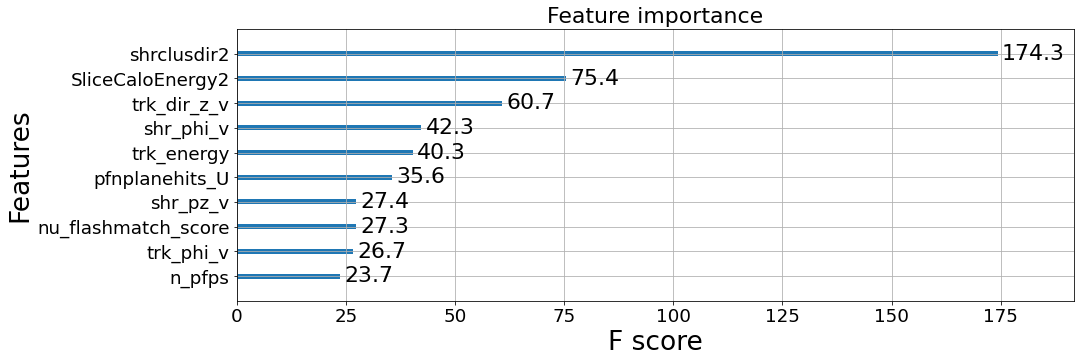

<Figure size 864x864 with 0 Axes>

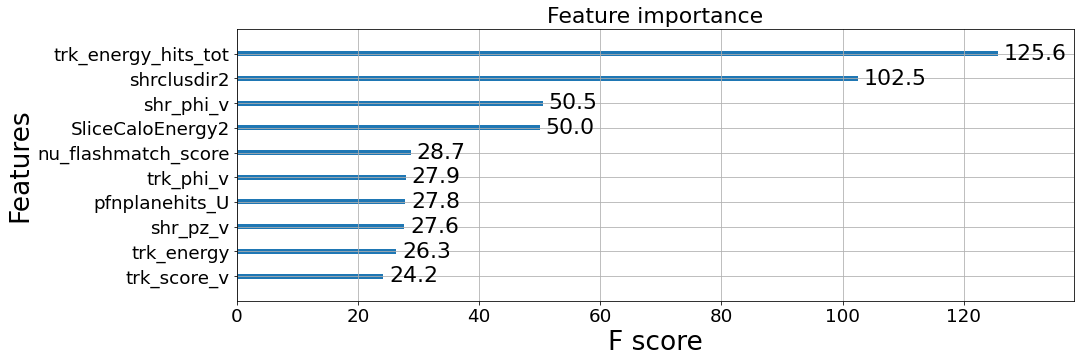

<Figure size 864x864 with 0 Axes>

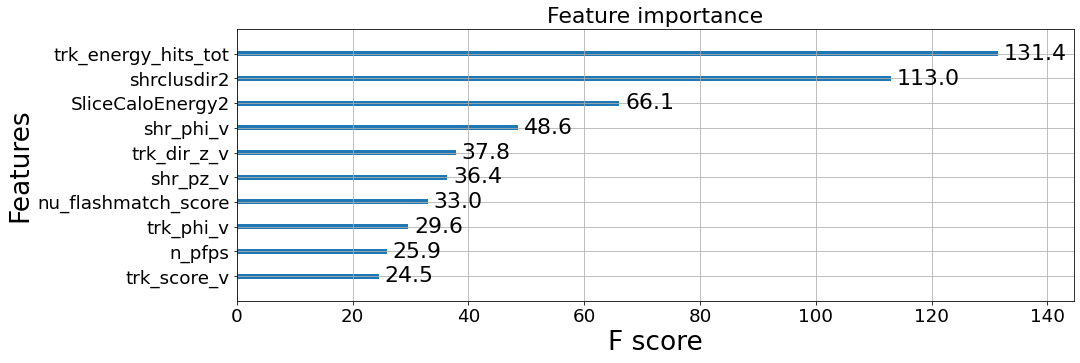

<Figure size 864x864 with 0 Axes>

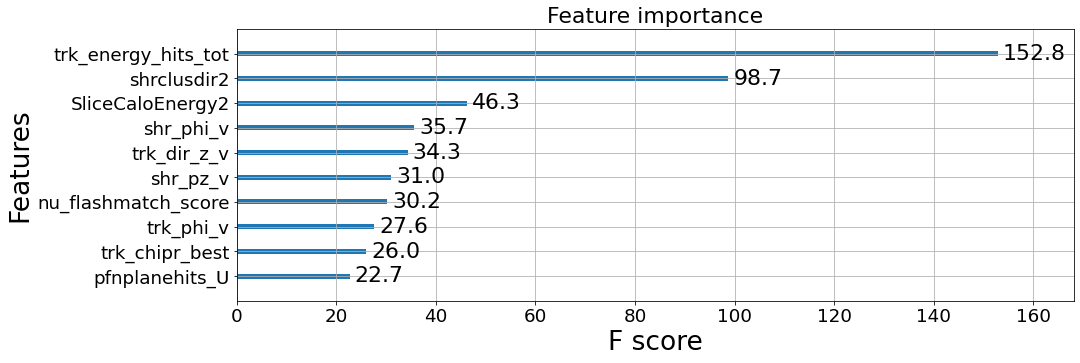

<Figure size 864x864 with 0 Axes>

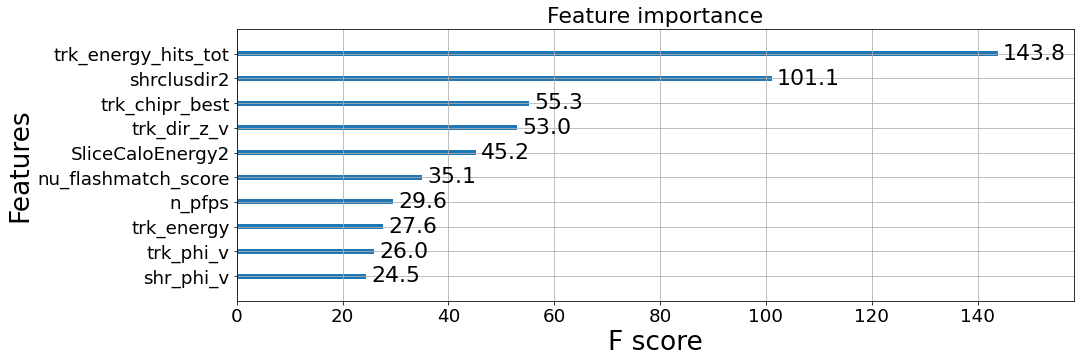

<Figure size 864x864 with 0 Axes>

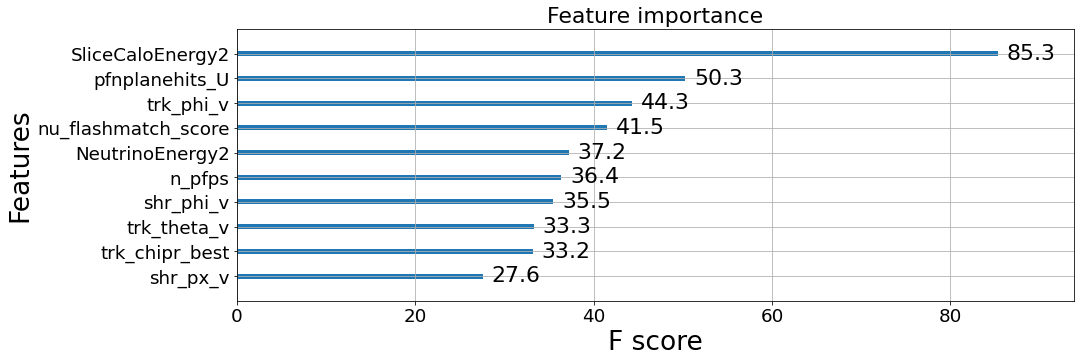

<Figure size 864x864 with 0 Axes>

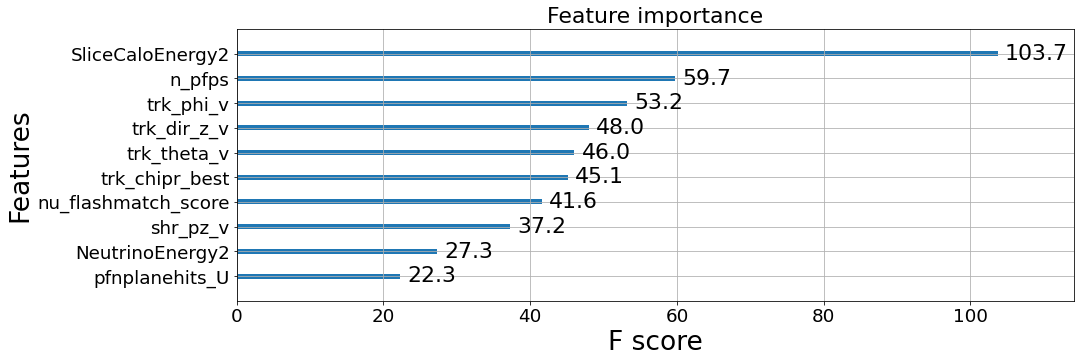

<Figure size 864x864 with 0 Axes>

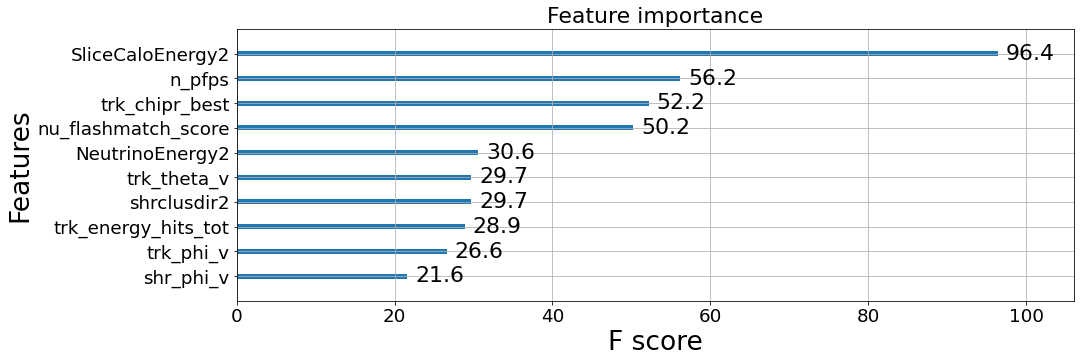

<Figure size 864x864 with 0 Axes>

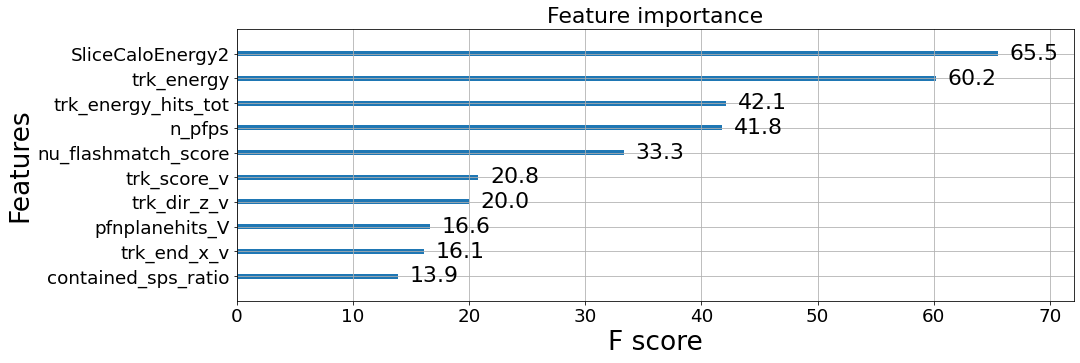

<Figure size 864x864 with 0 Axes>

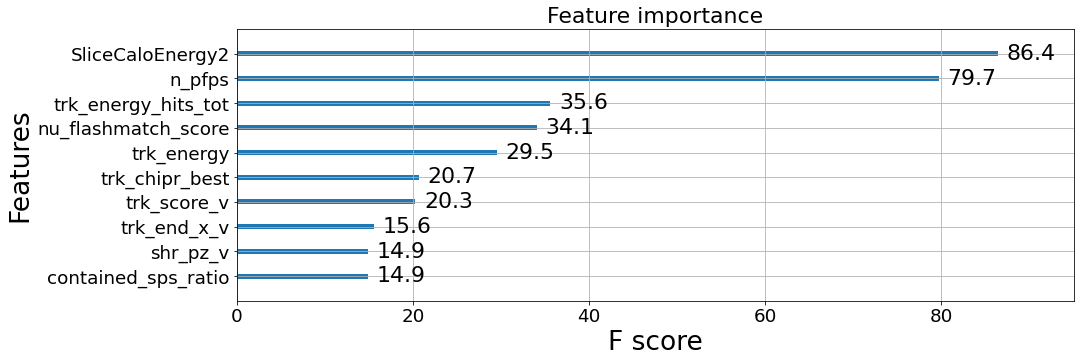

<Figure size 864x864 with 0 Axes>

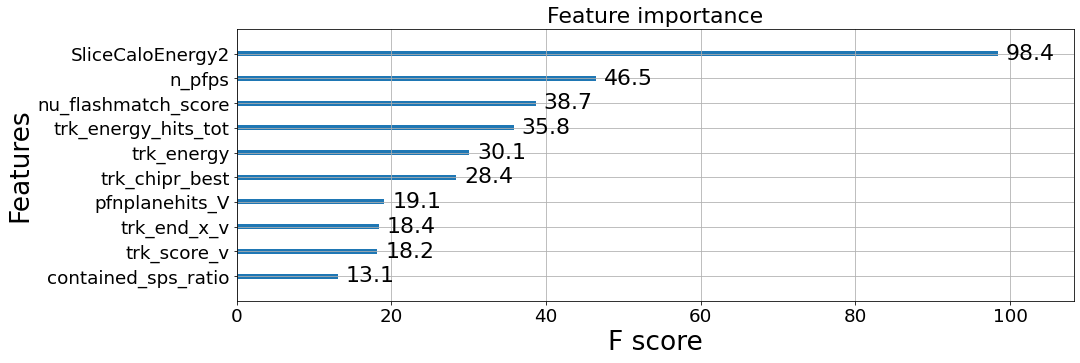

In [16]:
# dirt_matrix = xgboost.DMatrix(dirt_BDT[bdt_vars])
# EXT_matrix = xgboost.DMatrix(EXT_BDT[bdt_vars])

test_results_sig_dict = {}
test_results_bkg_dict = {}

train_results_sig_dict = {}
train_results_bkg_dict = {}

for HNL_mass in Constants.HNL_mass_samples:

    bdt = xgboost.Booster()
    bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_New_20_variables_FIXED.json")
    #bdt.load_model(f'bdts/{Run}_{HNL_mass}_MeV_REDUCED_variables_flattened_highest_E_2.json')
    
    importance = bdt.get_score(importance_type="gain")
    
    for key in importance.keys():
        importance[key] = round(importance[key],1)
        
    #importance_dict[HNL_mass] = importance

    results_sig = bdt.predict(xgb_test_dict[HNL_mass])
    results_bkg = bdt.predict(xgb_test_bkg)
    
    train_results_sig = bdt.predict(xgb_sig_train_dict[HNL_mass])
    train_results_bkg = bdt.predict(xgb_bkg_train_dict[HNL_mass])
    
    test_results_sig_dict.update({HNL_mass:results_sig})
    test_results_bkg_dict.update({HNL_mass:results_bkg})
    
    train_results_sig_dict.update({HNL_mass:train_results_sig})
    train_results_bkg_dict.update({HNL_mass:train_results_bkg})

    # results_dirt = bdt.predict(dirt_matrix)
    # results_EXT = bdt.predict(EXT_matrix)
    
    # dirt_BDT[f'BDT_output_{HNL_mass}MeV'] = results_dirt
    # EXT_BDT[f'BDT_output_{HNL_mass}MeV'] = results_EXT

    # overlay_test_BDT[f'BDT_output_{HNL_mass}MeV'] = results_bkg
    # #Can add in a second loop over HNL_masses so that I predict each signal mass point with every other mass point bdt
    # signal_test_BDT_dict[HNL_mass][f'BDT_output'] = results_sig
    
    #Plotting importances of variables
    plt.figure(figsize=(12,12),facecolor='white')
    print(f"Plotting {HNL_mass}MeV importances:")
    a = xgboost.plot_importance(importance,max_num_features=10,importance_type='gain')
    

## Test vs. Train

In [15]:
test_results_sig_dict

Index(['run', 'sub', 'evt', 'shr_energy_tot', 'shr_energy', 'shr_theta_v',
       'shr_pca_0', 'shr_pca_1', 'shr_pca_2', 'shr_phi_v',
       ...
       'extra_energy_y', 'slclustfrac', 'slnhits', 'pt', 'p_assume_muon',
       'CosmicIPAll3D', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y',
       'highest_E'],
      dtype='object', length=119)

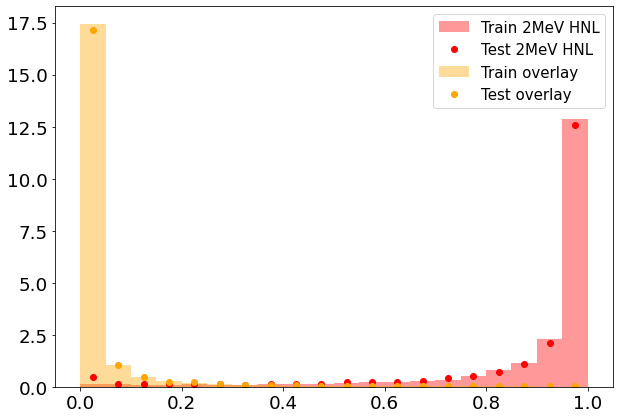

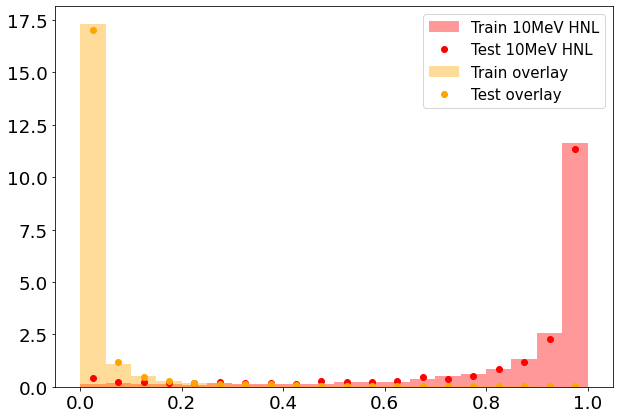

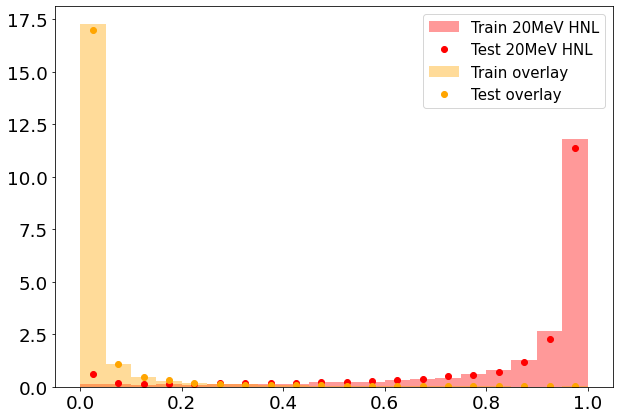

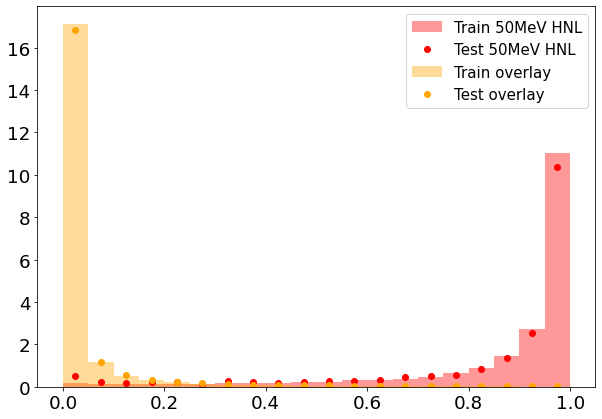

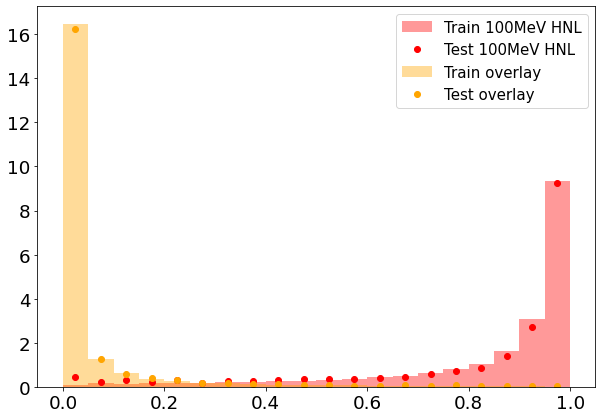

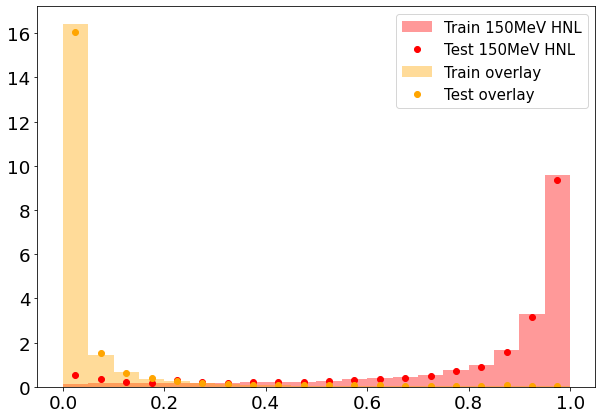

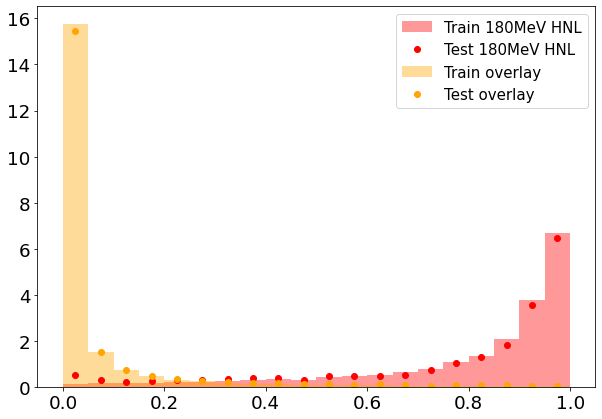

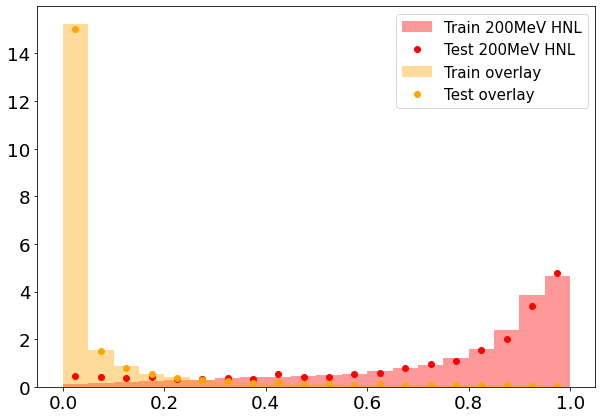

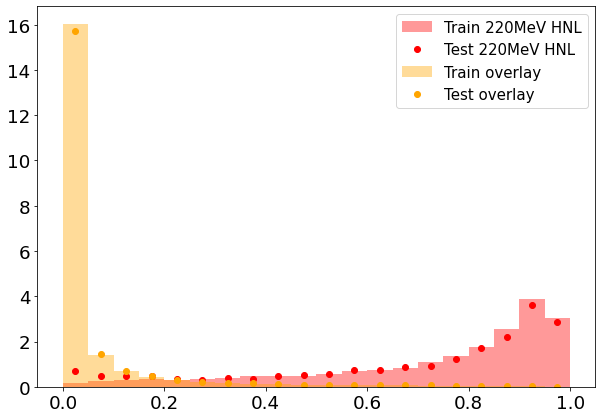

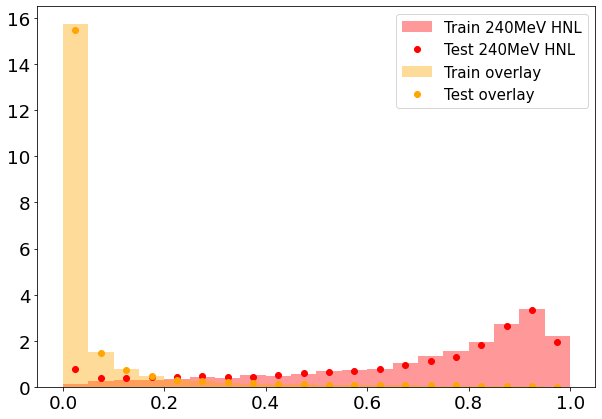

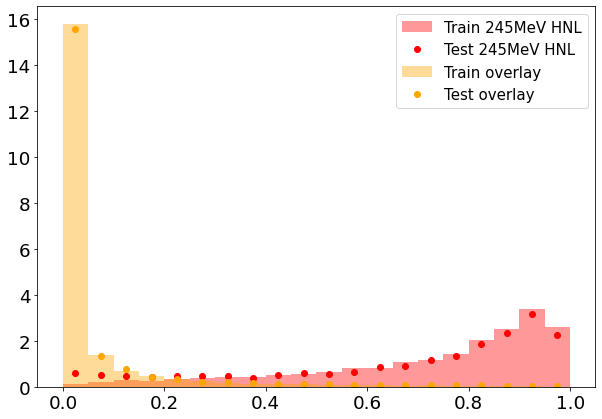

In [17]:
hist_range=[0,1.0]
n_bins=20

for HNL_mass in Constants.HNL_mass_samples:
    plt.figure(figsize=(10,7))
    plt.hist(train_results_sig_dict[HNL_mass],bins=n_bins, range=hist_range, density=True,alpha=0.4,color='red',label=f'Train {HNL_mass}MeV HNL' )
    counts,bin_edges = np.histogram(test_results_sig_dict[HNL_mass],bins=n_bins,range=hist_range,density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    plt.plot(bin_centers,counts,marker='o',linestyle="None",color='red',label=f'Test {HNL_mass}MeV HNL')

    plt.hist(train_results_bkg_dict[HNL_mass], bins = n_bins, range = hist_range, density = True, alpha = 0.4, color = 'orange', label = r'Train overlay')
    counts,bin_edges = np.histogram(test_results_bkg_dict[HNL_mass],bins = n_bins, range= hist_range,density = True)
    bin_centers = (bin_edges[:-1] +  bin_edges[1:])/2.
    plt.plot(bin_centers,counts,marker='o',linestyle ="None",color='orange',label = r'Test overlay')
    plt.legend()

In [9]:
# feature_names = ['shrclusdir0','shrclusdir1','shrclusdir2', 'shr_pca_1', 'shr_hits_max',
#                  'trk_chipr_best', 'trk_energy_hits_tot', 'trk_dir_z_v', 'trk_theta_v', 'trk_phi_v', 'trk_bragg_mip_v',
#                  'NeutrinoEnergy2', 'merge_bestdist', 'n_pfps', 'pfnplanehits_Y']
feature_names = Variables.First_pass_vars_for_BDT #All variables
feature_names_MC = feature_names + ["weight"]

HNL_masses = Constants.HNL_mass_samples #in MeV

Run = "run1" #Either "run1" or "run3" at the moment

loc_pkls = f"pkl_files/{Run}/current_files/my_vars/"

variables_string = "my_vars"
Flat_state = "flattened"

Load_standard = False
Load_DetVars = True

if Load_standard == True:
    print(f"Loading {Run} .pkls" + "\n")

    Presel_overlay = pd.read_pickle(loc_pkls+f"Preselected_overlay_{Run}_my_vars_flattened.pkl")
    Presel_dirt = pd.read_pickle(loc_pkls+f"Preselected_dirt_{Run}_my_vars_flattened.pkl")
    Presel_EXT = pd.read_pickle(loc_pkls+f"Preselected_EXT_{Run}_my_vars_flattened.pkl")

    signal_samples_dict = {}

    for HNL_mass in HNL_masses:
        Presel_signal = pd.read_pickle(loc_pkls+f"Preselected_signal_{HNL_mass}MeV_{Run}_my_vars_flattened.pkl")
        signal_samples_dict[HNL_mass] = Presel_signal

    print("Overlay .pkl is "+str(len(Presel_overlay))+" entries long.")
    print("Dirt .pkl is "+str(len(Presel_dirt))+" entries long.")
    print("EXT .pkl is "+str(len(Presel_EXT))+" entries long.")
    for HNL_mass in HNL_masses:
        print(f"{HNL_mass} Signal .pkl is "+str(len(signal_samples_dict[HNL_mass]))+" entries long.")

    print()
    print("Variables in overlay is " + str(len(Presel_overlay.keys())))
    print("Variables in dirt is " + str(len(Presel_dirt.keys())))
    print("Variables in EXT is " + str(len(Presel_EXT.keys())))
    for HNL_mass in HNL_masses:
        print(f"Variables in {HNL_mass}MeV Signal is " + str(len(signal_samples_dict[HNL_mass].keys())))

if Load_DetVars == True:
    DetVars = Constants.Detector_variations
    DetVar_samples = {}
    for DetVar in DetVars:
        placeholder = pd.read_pickle(loc_pkls+"DetVars/"+f"Preselected_overlay_{Run}_{variables_string}_{DetVar}_{Flat_state}.pkl")
        placeholder_dict = {DetVar:placeholder}
        DetVar_samples.update(placeholder_dict)
    print(DetVar_samples.keys())

dict_keys(['WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ', 'WireModdEdX', 'LYDown', 'LYRayleigh', 'LYAttenuation', 'SCE', 'Recomb2', 'CV'])


## Functions

In [10]:
def Prepare_dfs_for_xgb(df, variable_list, edited_vars): #The default value for missing data in XGB is 0. So this changes those very large negative values to -9999.
    value = -1e15
    new_value = -9999
    for variable in df.keys():
        if(len(df.loc[df[variable] < value]) > 0):
            edited_vars.append(variable)
            df.loc[(df[variable] < value), variable] = new_value #Sets the new value
        if(len(df.loc[df[variable] == -1.0]) > 0):
            edited_vars.append(variable)
            df.loc[(df[variable] == -1.0), variable] = new_value #Sets the new value
        if(len(df.loc[df[variable] == np.nan]) > 0):
            edited_vars.append(variable)
            df.loc[(df[variable] == np.nan), variable] = new_value #Sets the new value
        if(len(df.loc[df[variable] == np.inf]) > 0):
            edited_vars.append(variable)
            df.loc[(df[variable] == np.inf), variable] = new_value #Sets the new value
            
    df_edited = df[variable_list].copy() #Ensures the variable list is just those given, i.e removing any others
    return df_edited

def only_keep_highest_E(df):
    df["highest_E"]=df['pfnplanehits_Y'].groupby("entry").transform(max) == df['pfnplanehits_Y']
    df_new = df.query("highest_E").copy()
    return df_new
    

## Only keeping highest energy object per event

In [11]:
if Load_standard == True:
    overlay_highest_E = only_keep_highest_E(Presel_overlay)
    dirt_highest_E = only_keep_highest_E(Presel_dirt)
    EXT_highest_E = only_keep_highest_E(Presel_EXT)

    signal_dict_highest_E = {}
    for HNL_mass in HNL_masses:
        signal_dict_highest_E[HNL_mass] = only_keep_highest_E(signal_samples_dict[HNL_mass])

if Load_DetVars == True:
    DetVar_dict_highest_E = {}
    for DetVar in DetVars:
        DetVar_dict_highest_E[DetVar] = only_keep_highest_E(DetVar_samples[DetVar])

## Splitting samples into test and training

In [12]:
bdt_vars = feature_names

new_value = -9999 #This tells XGB what number refers to missing data for all variables

signal_train_dict = {}
signal_test_dict = {}
labels_dict = {} #I should try and understand what this is doing better

train_vs_test_fraction = 0.7

#data_bkg = Cleaned_Presel_overlay_highest_E
overlay = overlay_highest_E

overlay_train = overlay[int(len(overlay)*train_vs_test_fraction):]
overlay_test = overlay[:int(len(overlay)*train_vs_test_fraction)]

for HNL_mass in HNL_masses:
    signal_train_dict[HNL_mass] = signal_dict_highest_E[HNL_mass][int(len(signal_dict_highest_E[HNL_mass])*train_vs_test_fraction):]
    signal_test_dict[HNL_mass] = signal_dict_highest_E[HNL_mass][:int(len(signal_dict_highest_E[HNL_mass])*train_vs_test_fraction)]
    
    labels_dict[HNL_mass] = [1]*len(signal_train_dict[HNL_mass][bdt_vars]) + [0]*len(overlay_train[bdt_vars])
    print(len(signal_train_dict[HNL_mass])+len(overlay_train))
    print(len(labels_dict[HNL_mass]))
    print()


NameError: name 'overlay_highest_E' is not defined

## Deleting columns which shouldn't be trained on

In [7]:
vars_to_save = Variables.event_vars + Variables.weight_related + ['weight']

overlay_to_save = overlay_test[vars_to_save].copy()
dirt_to_save = dirt_highest_E[vars_to_save].copy()
EXT_to_save = EXT_highest_E[Variables.event_vars].copy()

signal_to_save_dict = {}
for HNL_mass in HNL_masses:
    signal_to_save_dict[HNL_mass] = signal_test_dict[HNL_mass][Variables.event_vars].copy()
    

edited_vars_overlay, edited_vars_dirt, edited_vars_EXT, edited_vars_signal = [], [], [], [] #Should probably get rid once I'm happy with what happens

overlay_train_BDT = Prepare_dfs_for_xgb(overlay_train, feature_names_MC, edited_vars_overlay)
overlay_test_BDT = Prepare_dfs_for_xgb(overlay_test, feature_names_MC, edited_vars_overlay)

dirt_BDT = Prepare_dfs_for_xgb(dirt_highest_E, feature_names_MC, edited_vars_dirt)
EXT_BDT = Prepare_dfs_for_xgb(EXT_highest_E, feature_names, edited_vars_EXT)

signal_train_BDT_dict = {}
signal_test_BDT_dict = {}
for HNL_mass in HNL_masses:
    signal_train_BDT_dict[HNL_mass] = Prepare_dfs_for_xgb(signal_train_dict[HNL_mass], feature_names, edited_vars_signal)
    signal_test_BDT_dict[HNL_mass] = Prepare_dfs_for_xgb(signal_test_dict[HNL_mass], feature_names, edited_vars_signal)

print("Variables in overlay is " + str(len(overlay_train_BDT.keys())))
print("Variables in dirt is " + str(len(dirt_BDT.keys())))
print("Variables in EXT is " + str(len(EXT_BDT.keys())))
for HNL_mass in HNL_masses:
    print(f"Variables in {HNL_mass}MeV Signal is " + str(len(signal_train_BDT_dict[HNL_mass].keys())))


Variables in overlay is 116
Variables in dirt is 116
Variables in EXT is 115
Variables in 20MeV Signal is 115
Variables in 50MeV Signal is 115
Variables in 100MeV Signal is 115
Variables in 150MeV Signal is 115
Variables in 180MeV Signal is 115
Variables in 200MeV Signal is 115


In [14]:
edited_vars_detvar = []
if Load_DetVars == True:
    DetVar_BDT_dict = {}
    for DetVar in Constants.Detector_variations:
        DetVar_BDT_dict[DetVar] = Prepare_dfs_for_xgb(DetVar_dict_highest_E[DetVar], feature_names_MC, edited_vars_detvar)
        print(DetVar)
        print(len(DetVar_BDT_dict[DetVar]), len(DetVar_dict_highest_E[DetVar]))
        

WireModX
7314 7314
WireModYZ
7354 7354
WireModThetaXZ
7343 7343
WireModThetaYZ
7431 7431
WireModdEdX
7157 7157
LYDown
7641 7641
LYRayleigh
7420 7420
LYAttenuation
7823 7823
SCE
7502 7502
Recomb2
7288 7288
CV
7339 7339


In [15]:
print(DetVar_BDT_dict.keys())
print(len(DetVar_BDT_dict['LYDown']))

dict_keys(['WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ', 'WireModdEdX', 'LYDown', 'LYRayleigh', 'LYAttenuation', 'SCE', 'Recomb2', 'CV'])
7641


# BDT test and training

In [10]:
#Making train and test samples
#Do I need to create new "random" training samples for each signal sample to train against? - so far have not

In [14]:
xgb_train_dict = {}
xgb_test_dict = {}

xgb_sig_train_dict = {}
xgb_bkg_train_dict = {}

xgb_test_bkg = xgboost.DMatrix(overlay_test_BDT[bdt_vars], label=[0]*len(overlay_test_BDT[bdt_vars]), missing=new_value, feature_names=bdt_vars)

param = {'booster': 'dart',
        'max_depth':6,
        'eta':0.3,
        'objective':'binary:logistic',
#         'eval_metric':'auc', 
#        'subsample':0.5,
        'tree_method':'hist',
#         'scale_pos_weight': float(len(data_bkg_train))/float(len(data_sig_train)),
        'rate_drop': 0.1,
        'skip_drop': 0.5 }
num_round = 50
progress = dict()

for HNL_mass in Constants.HNL_mass_samples:
    xgb_train_dict[HNL_mass] = xgboost.DMatrix(pd.concat([signal_train_BDT_dict[HNL_mass][bdt_vars], 
                                                               overlay_train_BDT[bdt_vars]]), 
                                               label=labels_dict[HNL_mass], 
                                                    missing=new_value, feature_names=bdt_vars)
    xgb_test_dict[HNL_mass] = xgboost.DMatrix(signal_test_BDT_dict[HNL_mass][bdt_vars], label=[1]*len(signal_test_BDT_dict[HNL_mass][bdt_vars]),
                                              missing=new_value, feature_names=bdt_vars)
    
    xgb_sig_train_dict[HNL_mass] = xgboost.DMatrix(signal_train_BDT_dict[HNL_mass][bdt_vars],label=[1]*len(signal_train_BDT_dict[HNL_mass][bdt_vars]),
                                                  missing=new_value, feature_names=bdt_vars)
    xgb_bkg_train_dict[HNL_mass] = xgboost.DMatrix(overlay_train_BDT[bdt_vars],label=[0]*len(overlay_train_BDT[bdt_vars]),
                                                  missing=new_value, feature_names=bdt_vars)

    #watchlist so that you can monitor the performance of the training by iterations
    watchlist = [(xgb_train_dict[HNL_mass], 'train'), (xgb_test_dict[HNL_mass], 'test_sig'),(xgb_test_bkg,'test_bkg')]

NameError: name 'overlay_test_BDT' is not defined

In [13]:
print_vals = input("Do you want to retrain the BDTs? y/n ")
if print_vals == "y":
    for HNL_mass in HNL_masses:
        print(f"Training {HNL_mass} MeV BDT" + "\n")
        bdt = xgboost.train(param, xgb_train_dict[HNL_mass], num_round, watchlist,evals_result=progress, verbose_eval=False)
        # doesnt like watchlist/eval_result if using AOC
        # save model so you can load it later
        bdt.save_model(f'bdts/{Run}_{HNL_mass}_MeV_My_variables_flattened_highest_E_3.json')
        #bdt.save_model(f'bdts/{Run}_{HNL_mass}_MeV_REDUCED_variables_flattened_highest_E_3.json')
    
else: 
    print("Not retraining BDTs, will load previous models in next cell")

Do you want to retrain the BDTs? y/n  y


Training 20 MeV BDT

[18:13:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training 50 MeV BDT

[18:13:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training 100 MeV BDT

[18:13:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if y

In [17]:
bdt_vars = feature_names
if Load_DetVars == True:
    DetVars_matrices = {}
    for DetVar in Constants.Detector_variations:
        DetVars_matrices[DetVar] = xgboost.DMatrix(DetVar_BDT_dict[DetVar][bdt_vars])

    for HNL_mass in HNL_masses:

        bdt = xgboost.Booster()
        bdt.load_model(f'bdts/{Run}_{HNL_mass}_MeV_My_variables_flattened_highest_E_3.json')
        for DetVar in Constants.Detector_variations:
            results = bdt.predict(DetVars_matrices[DetVar])
            # print(DetVar)
            # print(len(results))
            DetVar_BDT_dict[DetVar][f'BDT_output_{HNL_mass}MeV'] = results

## Saving .pkl files of the selected dataframes with BDT score branches

In [33]:
pkl_results_loc = f'pkl_files/{Run}/current_files/Results/'

print_vals = input("Do you want to save the new BDT scores to .pkl files? y/n ")
if print_vals == "y":
    
    labels = Variables.event_vars + Variables.weight_related + ["weight"]
    
    for HNL_mass in HNL_masses:
        labels.append(f'BDT_output_{HNL_mass}MeV')
    print(labels)
    
    overlay_merged = pd.concat([overlay_test_BDT,overlay_to_save], axis=1)

    print(overlay_merged.head())
    
    overlay_merged_to_save = overlay_merged[labels] #Have duplicated "weight" column now, need to fix
    df2 = overlay_merged_to_save.loc[:,~overlay_merged_to_save.columns.duplicated()] #Getting rid of duplicate "weight" column
    df2.to_pickle(pkl_results_loc + "overlay_test2.pkl")
    
    print(df2.keys())
    
#     overlay_to_save = data_test_bkg[labels]
#     overlay_to_save.head()
    
#     data_test_bkg
#     signal_test_dict[HNL_mass]
    
#     Cleaned_Presel_dirt_highest_E
#     Cleaned_Presel_EXT_highest_E
#     new_overlay.to_pickle(loc_pkls+f"overlay_{Run}_{variables_string}_"+Flat_state+".pkl")

else: 
    print("Not saving .pkl files with BDT scores")

Do you want to save the new BDT scores to .pkl files? y/n  y


['run', 'sub', 'evt', 'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'weight', 'BDT_output_20MeV', 'BDT_output_50MeV', 'BDT_output_100MeV', 'BDT_output_150MeV', 'BDT_output_180MeV', 'BDT_output_200MeV']
                shr_energy_tot  shr_energy  shr_theta_v    shr_pca_0  \
entry subentry                                                         
0     0               0.000000    0.000000     1.249664 -9999.000000   
16    0               0.088654    0.077528     1.045234    26.224998   
32    0               0.313125    0.313125     1.055043   110.687485   
146   0               0.048661    0.048661     1.041765    21.493940   
162   0               0.000000    0.000000     0.691677 -9999.000000   

                  shr_pca_1    shr_pca_2  shr_phi_v  shr_px_v  shr_py_v  \
entry subentry                                                            
0     0        -9999.000000 -9999.000000   2.581282 -0.803786  0.504281   
16    0            1.948777     0.253073   2.857569 -0.830385  0.24240

## Plotting BDT Output

In [11]:
#Plotting BDT output after only keeping highest bdt score per event

for HNL_mass in HNL_masses:
    # plt.figure(figsize=(12,8),facecolor='white')
    numdecays_signal = len(cleaned_signal_dict_highest_E[HNL_mass])
    numdecays_bkg = len(Cleaned_Presel_overlay_highest_E)
    SF_sig = numdecays_signal/len(signal_test_dict[HNL_mass][f'BDT_output'])
    SF_overlay = (numdecays_bkg)/len(data_test_bkg[f'BDT_output_{HNL_mass}MeV'])
    
    # print("Scale factor for signal is " + str(SF_sig)) #Should have a dict of SF_sig and SF_overlay
    # print("Scale factor for overlay is " + str(SF_overlay))
    
    if Run == "run1":
        SF_overlay_run1_corrected = Constants.SF_overlay_run1*SF_overlay #Necessary to account for the events used for training
        SF_signal_run1_corrected = SF_sig #Necessary to account for the events used for training
        EXT_scale_list = np.ones(len(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
        EXT_scale = Constants.SF_EXT_run1
        dirt_scale = Constants.SF_dirt_run1
        signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_signal_run1_corrected
        overlay_scale = SF_overlay_run1_corrected
        
    elif Run == "run3":
        SF_overlay_run3_corrected = Constants.SF_overlay_run3*SF_overlay #Necessary to account for the events used for training
        SF_signal_run3_corrected = SF_sig #Necessary to account for the events used for training
        EXT_scale_list = np.ones(len(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3
        EXT_scale = Constants.SF_EXT_run3
        dirt_scale = Constants.SF_dirt_run3
        signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_signal_run3_corrected
        overlay_scale = SF_overlay_run3_corrected

print("Creating the sample and normalisation dictionaries")    
samples={'overlay_test':data_test_bkg,
         'dirtoverlay':Cleaned_Presel_dirt_highest_E,
         'beamoff':Cleaned_Presel_EXT_highest_E}

sample_norms={'overlay_test':np.array(data_test_bkg["weight"]*overlay_scale),
         'dirtoverlay':np.array(Cleaned_Presel_dirt_highest_E["weight"]*dirt_scale),
         'beamoff':EXT_scale_list}

print("Adding signal samples to sample dictionary")
for HNL_mass in HNL_masses:
    signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_sig
    
    sample_placeholder = {HNL_mass:signal_test_dict[HNL_mass]}
    norm_placeholder = {HNL_mass:signal_scale_list}
    samples.update(sample_placeholder)
    sample_norms.update(norm_placeholder)
    print(len(sample_norms[HNL_mass]))

Creating the sample and normalisation dictionaries
Adding signal samples to sample dictionary
10180
9712
9154
10079
8632
8740


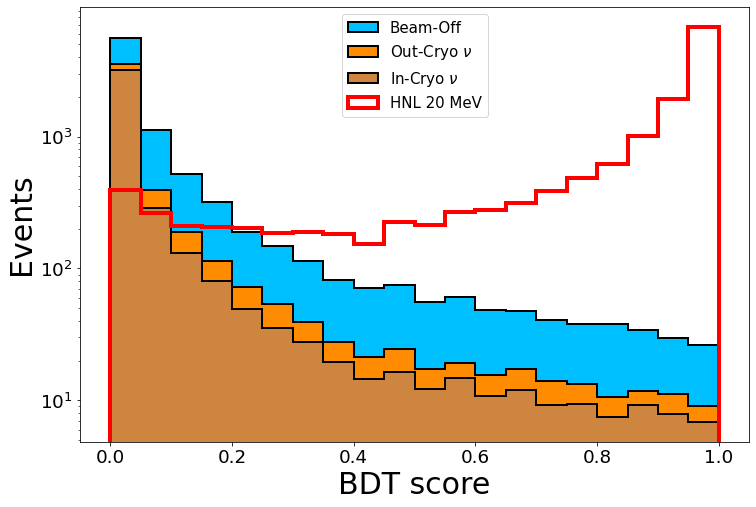

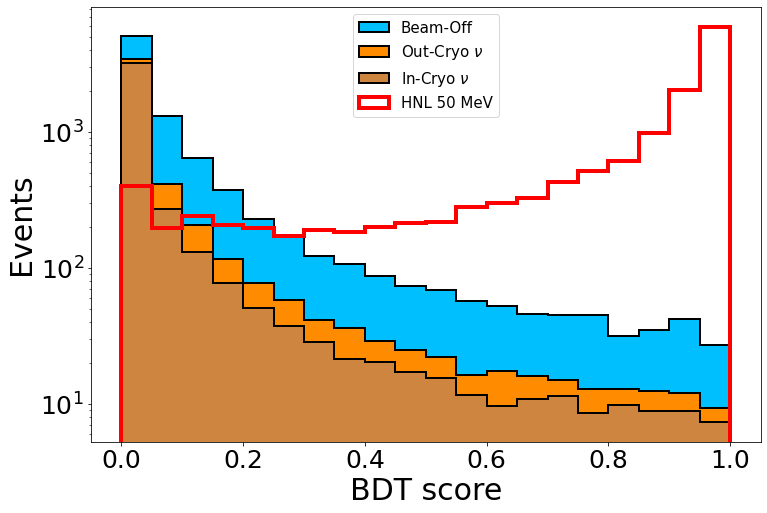

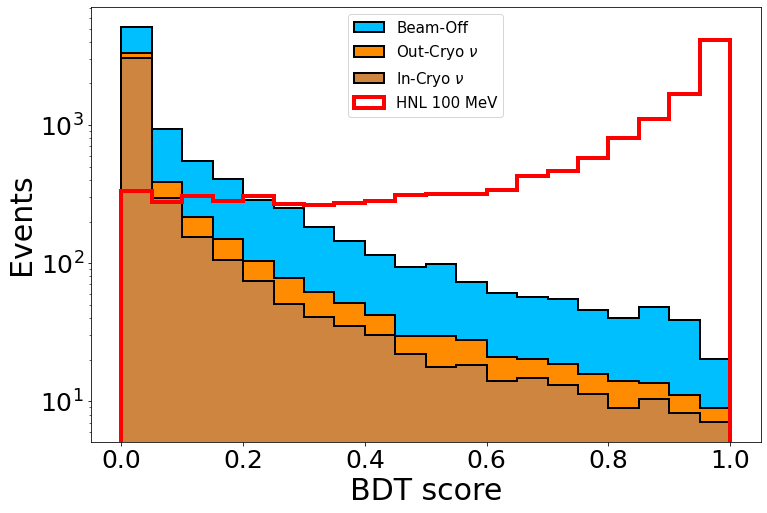

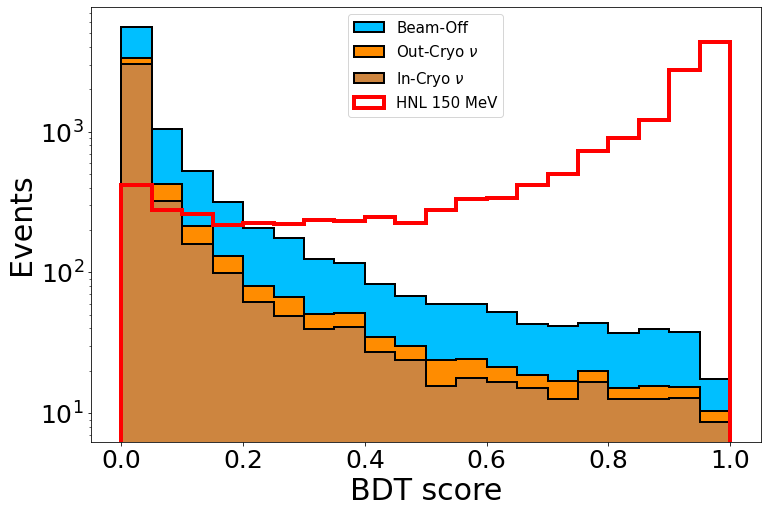

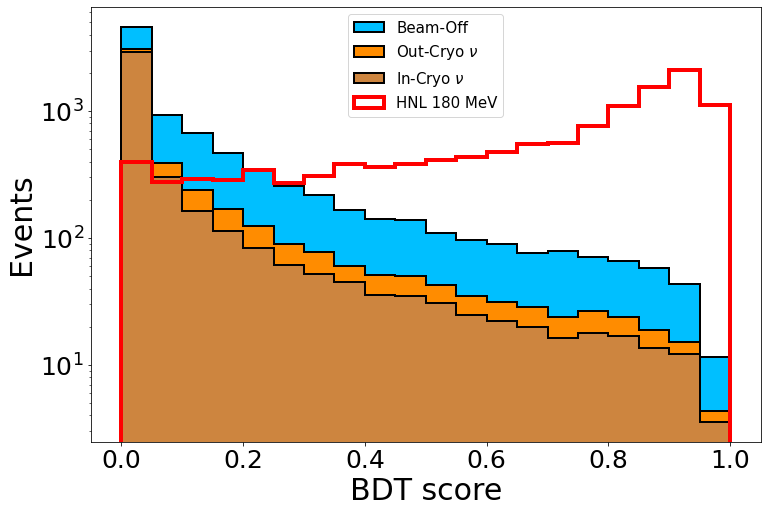

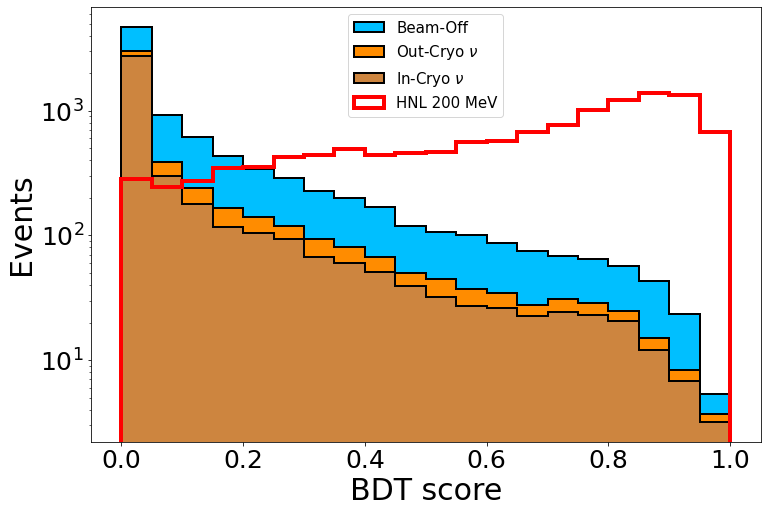

In [12]:
PT.Plot_BDT_output(HNL_masses=HNL_masses, samples=samples, sample_norms=sample_norms, colours={}, xlims=[0,1.0],
                bins=20,figsize=[12,8], MergeBins=False, density=False, legloc="upper center",logy=True, savefig=False, Run=Run)

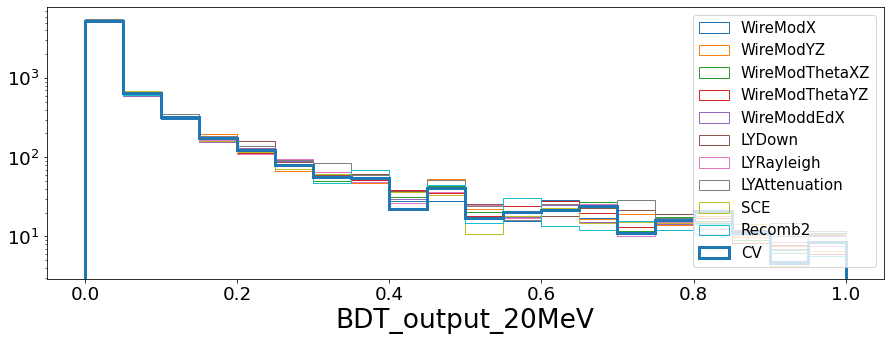

In [19]:
#Plotting the histograms for detector variations
HNL_mass = 20
if Load_DetVars == True:
    for DetVar in DetVar_BDT_dict:
        linewidth = 1
        if DetVar == "CV":
            linewidth = 3
        plt.hist(DetVar_BDT_dict[DetVar][f'BDT_output_{HNL_mass}MeV'], weights=DetVar_BDT_dict[DetVar]["weight"], bins=20,range=[0,1.0],label=f'{DetVar}',
                 lw=linewidth,histtype="step")
    plt.xlabel(f'BDT_output_{HNL_mass}MeV')
    plt.legend()
    plt.yscale("log")

[-1.8244802951812744, -1.0230541229248047, 3.381013870239258, 6.5079569816589355, 5.354964733123779, -9.78671908378601, -2.902376651763916, -5.597281455993652, 6.0204267501831055, 9.922075271606445, 1.5978693962097168, 2.6834845542907715, 13.424599170684814, 59.31296348571777, -16.81797504425049, 1.7949461936950684, -5.350255966186523, -3.6128580570220947, -21.414464712142944, 28.98259162902832]


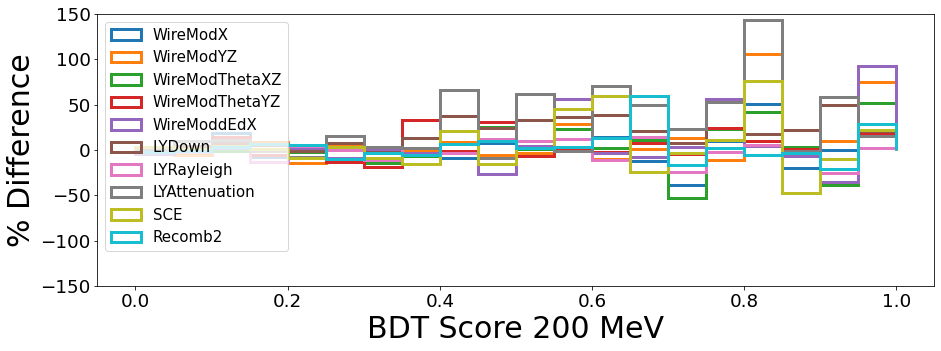

In [52]:
DetVar_percentages_dict = {}
if Load_DetVars == True:
    cv_hist, cv_bins = np.histogram(
        DetVar_BDT_dict["CV"][f'BDT_output_{HNL_mass}MeV'],
        range=[0,1.0],
        bins=20,
        weights=DetVar_BDT_dict["CV"]["weight"])
    bins_cent=(cv_bins[:-1]+cv_bins[1:])/2
    for DetVar in DetVar_BDT_dict:
        if DetVar == "CV":
            continue
        perc_list = []
        detvar_hist, bins = np.histogram(
        DetVar_BDT_dict[DetVar][f'BDT_output_{HNL_mass}MeV'],
        range=[0,1.0],
        bins=20,
        weights=DetVar_BDT_dict[DetVar]["weight"])
        for i in range(len(detvar_hist)):
            frac = detvar_hist[i]/cv_hist[i]
            frac_diff = frac - 1.0
            perc_list.append(frac_diff*100)
        DetVar_percentages_dict[DetVar] = perc_list
        plt.hist(bins_cent,weights=DetVar_percentages_dict[DetVar], bins=20,range=[0,1.0],label=f'{DetVar}',
                lw=linewidth,histtype="step") #just 1 entry for each bin, then "weight" becomes what the percentage is (hacky way, could do something nicer)
    plt.legend(loc='upper left',frameon=True)
    plt.ylim([-150,150])
    plt.xlabel(f'BDT Score {HNL_mass} MeV', fontsize=30)
    plt.ylabel('% Difference', fontsize=30)
    #plt.yscale()

# Function for saving histograms

In [13]:
def SaveToRoot(nbins,xlims,bkg_overlay,bkg_dirt,bkg_EXT,sig,data,fileName='test.root'):
    nBins = nbins
    binLimits = xlims
  ### Save files 
    rFile = ROOT.TFile(f'bdt_output/{fileName}','RECREATE')
    tData1 = ROOT.TH1F("Signal","Signal",nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData1.SetBinContent(i+1,sig['hist'][i])
        tData1.SetBinError(i+1,sig['err'][i])
    tData2 = ROOT.TH1F("bkg_overlay","bkg_overlay",nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData2.SetBinContent(i+1,bkg_overlay['hist'][i])
        tData2.SetBinError(i+1,bkg_overlay['err'][i])
    tData3 = ROOT.TH1F("bkg_dirt","bkg_dirt",nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData3.SetBinContent(i+1,bkg_dirt['hist'][i])
        tData3.SetBinError(i+1,bkg_dirt['err'][i])
    tData4 = ROOT.TH1F("bkg_EXT","bkg_EXT",nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData4.SetBinContent(i+1,bkg_EXT['hist'][i])
        tData4.SetBinError(i+1,bkg_EXT['err'][i])
    tData5 = ROOT.TH1F("Data","Data",nBins,binLimits[0],binLimits[1])
    for i in range(nBins):
        tData5.SetBinContent(i+1,data['hist'][i])
        tData5.SetBinError(i+1,data['err'][i])
    rFile.Write()
    rFile.Close()

# Saving output to .root files

In [14]:
original_theta = Constants.theta_mu_4

SCALE_UP_dict = {20:200, #Doing this because the scale factor used in pyhf is bounded, should be able to change this within pyhf
                50:50,
                100:10,
                150:5,
                180:5,
                200:2}

SCALE_UP_dict_run3 = {20:200, #Doing this because the scale factor used in pyhf is bounded, should be able to change this within pyhf
                50:50,
                100:10,
                150:5,
                180:5,
                200:2}

new_theta_dict = {}

for HNL_mass in HNL_masses:

    numdecays_signal = len(cleaned_signal_dict_highest_E[HNL_mass])
    numdecays_bkg = len(Cleaned_Presel_overlay_highest_E)
    
    SF_sig = numdecays_signal/len(signal_test_dict[HNL_mass][f'BDT_output'])
    SF_overlay = (numdecays_bkg)/len(data_test_bkg[f'BDT_output_{HNL_mass}MeV'])
    print("Scale factor for signal is " + str(SF_sig)) #Should have a dict of SF_sig and SF_overlay
    print("Scale factor for overlay is " + str(SF_overlay))
    
    if Run == "run1":
        new_theta_dict[HNL_mass] = original_theta*SCALE_UP_dict[HNL_mass]
    elif Run == "run3":
        new_theta_dict[HNL_mass] = original_theta*SCALE_UP_dict_run3[HNL_mass]
    SCALE_EVENTS = SCALE_UP_dict[HNL_mass]**4 #The Number of events is proportional to theta^4
    print(str(SCALE_EVENTS)+"\n")

    if Run == "run1":
        SF_overlay_run1_corrected = Constants.SF_overlay_run1*SF_overlay #Necessary to account for the events used for training
        SF_signal_run1_corrected = Constants.run1_POT_scaling_dict[HNL_mass]*SF_sig*SCALE_EVENTS #Necessary to account for the events used for training
        EXT_scale_list = np.ones(len(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
        EXT_scale = Constants.SF_EXT_run3
        dirt_scale = Constants.SF_dirt_run1
        
    elif Run == "run3":
        SF_overlay_run1_corrected = Constants.SF_overlay_run3*SF_overlay #Necessary to account for the events used for training
        SF_signal_run1_corrected = Constants.run3_POT_scaling_dict[HNL_mass]*SF_sig*SCALE_EVENTS #Necessary to account for the events used for training
        EXT_scale_list = np.ones(len(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3
        EXT_scale = Constants.SF_EXT_run3
        dirt_scale = Constants.SF_dirt_run3
    
    signal_scale_list = np.ones(len(signal_test_dict[HNL_mass][f'BDT_output']))*SF_signal_run1_corrected

    #Create and scale the histograms

    signal_bdt_hist = np.histogram(signal_test_dict[HNL_mass][f'BDT_output'], bins=20, weights=signal_scale_list, range = (0.0,1.0))
    overlay_bdt_hist = np.histogram(data_test_bkg[f'BDT_output_{HNL_mass}MeV'], bins=20, weights=data_test_bkg["weight"]*SF_overlay_run1_corrected, range = (0.0,1.0))
    dirt_bdt_hist = np.histogram(Cleaned_Presel_dirt_highest_E[f'BDT_output_{HNL_mass}MeV'], bins=20, weights=Cleaned_Presel_dirt_highest_E["weight"]*dirt_scale, range = (0.0,1.0))
    EXT_bdt_hist = np.histogram(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV'], bins=20, weights=EXT_scale_list, range = (0.0,1.0))
    
    #Error on any bin is sqrt(N)*scaling
    signal_err = []
    bkg_err = []
    dirt_err = []
    EXT_err = []
    bdt_sig_arr = [] #Do I need this for anything? remove if not
    bdt_bkg_arr = []


    #Need to make sure the histograms have weighted but not scaled events
    for i in range(0,len(signal_bdt_hist[0])):
        error = np.sqrt(signal_bdt_hist[0][i])*np.sqrt(SF_signal_run1_corrected)
        signal_err.append(error)
    
    for i in range(0,len(overlay_bdt_hist[0])):
        error = np.sqrt(overlay_bdt_hist[0][i])*np.sqrt(SF_overlay_run1_corrected)
        bkg_err.append(error)
    
    for i in range(0,len(dirt_bdt_hist[0])):
        error = np.sqrt(dirt_bdt_hist[0][i])*np.sqrt(dirt_scale)
        dirt_err.append(error)
    
    for i in range(0,len(EXT_bdt_hist[0])):
        error = np.sqrt(EXT_bdt_hist[0][i])*np.sqrt(EXT_scale)
        EXT_err.append(error)
    
    bb = overlay_bdt_hist[1]
    hb = overlay_bdt_hist[0]
    eb = bkg_err
    bs = signal_bdt_hist[1]
    hs = signal_bdt_hist[0]
    es = signal_err
    bd = dirt_bdt_hist[1]
    hd = dirt_bdt_hist[0]
    ed = dirt_err
    be = EXT_bdt_hist[1]
    he = EXT_bdt_hist[0]
    ee = EXT_err
    
    data_b = overlay_bdt_hist[1]
    data_h = overlay_bdt_hist[0]+dirt_bdt_hist[0]+EXT_bdt_hist[0]
    data_e = bkg_err
    
    #Create output products
    bkg_overlay = {'bins': np.array(bb), 'hist': np.array(hb), 'err': np.array(eb)}
    bkg_dirt = {'bins': np.array(bd), 'hist': np.array(hd), 'err': np.array(ed)}
    bkg_EXT = {'bins': np.array(be), 'hist': np.array(he), 'err': np.array(ee)}
    sig = {'bins': np.array(bs), 'hist': np.array(hs), 'err': np.array(es)}
    data = {'bins': np.array(data_b), 'hist': np.array(data_h), 'err': np.array(data_e)} #Should be added bkgs, with errors in quadrature


    SaveToRoot(20,[0,1.0],bkg_overlay,bkg_dirt,bkg_EXT,sig,data,fileName=f'{Run}_{HNL_mass}MeV_test2.root')
    
print("New (scaled) thetas are:")
print(new_theta_dict)

Scale factor for signal is 1.4285714285714286
Scale factor for overlay is 1.4285910778964743
1600000000

Scale factor for signal is 1.4286214748642494
Scale factor for overlay is 1.4285910778964743
6250000

Scale factor for signal is 1.4286085375357174
Scale factor for overlay is 1.4285910778964743
10000

Scale factor for signal is 1.4285944681880494
Scale factor for overlay is 1.4285910778964743
625

Scale factor for signal is 1.4286220646876384
Scale factor for overlay is 1.4285910778964743
625

Scale factor for signal is 1.4286107038123168
Scale factor for overlay is 1.4285910778964743
16

New (scaled) thetas are:
{20: 0.02, 50: 0.005, 100: 0.001, 150: 0.0005, 180: 0.0005, 200: 0.0002}


## Checking importance correlations

In [ ]:
#Taken from Luis' code
# for HNL_mass in HNL_masses:
method = 'kendall'
correlations = cleaned_signal_dict[100][bdt_vars].astype(np.float64).corr(method=method)
plt.figure(figsize=(15,12))
sns.heatmap(correlations,vmin=-1,annot=False,square=True,cbar_kws={'label':method+' correlation'},cmap = 'RdBu_r')
plt.title('Input Variable Correlations')
plt.show()

In [ ]:
#Just looking at most correlated 
corr=cleaned_signal_dict[100][bdt_vars].corr()
high_corr_var=np.where(corr>0.95)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

## Loading models

<class 'matplotlib.axes._subplots.AxesSubplot'>


<Figure size 864x864 with 0 Axes>

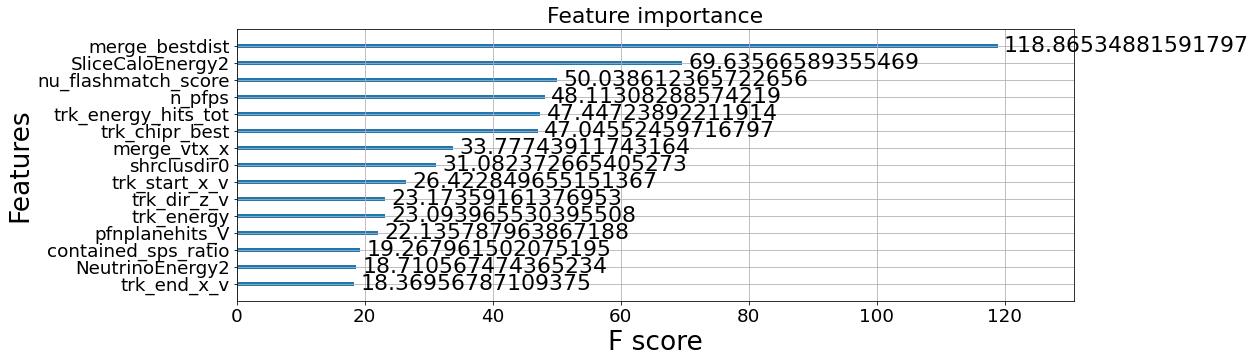

In [3]:
HNL_mass = 200

first_model = xgboost.Booster()
first_model.load_model(f'bdts/{Run}_{HNL_mass}_MeV_My_variables_flattened_highest_E_1.json')

plt.figure(figsize=(12,12),facecolor='white')

a = xgboost.plot_importance(first_model,max_num_features=15,importance_type='gain')

print(type(a))  

#Owen's dropdupes from the plotting function
# overlay_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])
# dirt_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])
# EXT_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])
# signal_post_bdt=data_test_bkg.sort_values('BDT_output',ascending=False).drop_duplicates(subset=["run","evt","sub"])

In [30]:
imp_dict = first_model.get_score(importance_type='gain')

value = 15
highest_imp = []

for k in imp_dict:
    if imp_dict[k] > value:
        highest_imp.append(k)
    
print(highest_imp)

['shr_theta_v', 'shr_phi_v', 'shr_start_x_v', 'shr_hits_max', 'trk_phi_v', 'trk_energy', 'trk_energy_hits_tot', 'trk_score_v', 'trk_chipr_best', 'trk_bragg_mip_v', 'trk_start_x_v', 'trk_dir_z_v', 'n_pfps', 'shrclusdir0', 'shrclusdir1', 'shrclusdir2', 'nu_flashmatch_score', 'NeutrinoEnergy2', 'SliceCaloEnergy2', 'pi0_dir1_z', 'pi0_dir2_z', 'p_assume_muon']


In [ ]:
#Plotting unweighted

for HNL_mass in HNL_masses:
    
    numdecays_signal = len(signal_samples_dict[HNL_mass])
    #numdecays_bkg = len(Presel_overlay)
    numdecays_bkg = len(Cleaned_Presel_overlay_highest_E)
    plt.figure(figsize=(12,8),facecolor='white')
    SF_sig = numdecays_signal/len(signal_test_dict[HNL_mass][f'BDT_output'])
    SF_overlay = (numdecays_bkg)/len(data_test_bkg[f'BDT_output_{HNL_mass}MeV'])
    print(len(signal_test_dict[HNL_mass][f'BDT_output'])*SF_sig)
    print(len(data_test_bkg[f'BDT_output_{HNL_mass}MeV'])*SF_overlay)

    plt.hist(data_test_bkg[f'BDT_output_{HNL_mass}MeV'],bins=20,range = [0.0,1.0], color='blue', label='Neutrino bkg', alpha=0.8)
    plt.hist(signal_test_dict[HNL_mass][f'BDT_output'],bins=20,range = [0.0,1.0], color='red', label=f'HNL {HNL_mass} MeV', alpha=0.8)
    plt.hist(Cleaned_Presel_dirt_highest_E[f'BDT_output_{HNL_mass}MeV'],bins=20,range = [0.0,1.0], color='orange', label='Dirt bkg', alpha=0.8)
    plt.hist(Cleaned_Presel_EXT_highest_E[f'BDT_output_{HNL_mass}MeV'],bins=20,range = [0.0,1.0], color='green', label=f'EXT bkg', alpha=0.8)

    plt.xlabel('BDT score', fontsize=30)
    plt.ylabel('Entries', fontsize=30)
    plt.rcParams.update({'font.size': 30})
    plt.legend()
    plt.yscale("log")
    plt.show()


In [ ]:
#Need to loop over  HNL_mass points and save new dataframes only keeping highest BDT rows for each 

print("Number of entries in the overlay: " + str(len(data_test_bkg)))
print("Number of entries in the dirt: " + str(len(Cleaned_Presel_dirt)))
print("Number of entries in the EXT: " + str(len(Cleaned_Presel_EXT)))

overlay_post_bdt_dict = {}
dirt_post_bdt_dict = {}
EXT_post_bdt_dict = {}
signal_post_bdt_dict = {}

for HNL_mass in HNL_masses:
    print(f"Number of entries in the {HNL_mass}MeV signal: " + str(len(signal_test_dict[HNL_mass])))

    data_test_bkg[f"highest_bdt_score_{HNL_mass}"]=data_test_bkg[f'BDT_output_{HNL_mass}MeV'].groupby("entry").transform(max) == data_test_bkg[f'BDT_output_{HNL_mass}MeV']
    Cleaned_Presel_dirt[f"highest_bdt_score_{HNL_mass}"]=Cleaned_Presel_dirt[f'BDT_output_{HNL_mass}MeV'].groupby("entry").transform(max) == Cleaned_Presel_dirt[f'BDT_output_{HNL_mass}MeV']
    Cleaned_Presel_EXT[f"highest_bdt_score_{HNL_mass}"]=Cleaned_Presel_EXT[f'BDT_output_{HNL_mass}MeV'].groupby("entry").transform(max) == Cleaned_Presel_EXT[f'BDT_output_{HNL_mass}MeV']
    signal_test_dict[HNL_mass][f"highest_bdt_score"]=signal_test_dict[HNL_mass]['BDT_output'].groupby("entry").transform(max) == signal_test_dict[HNL_mass]['BDT_output']

    overlay_post_bdt_dict[HNL_mass] = data_test_bkg.query(f"highest_bdt_score_{HNL_mass}")
    dirt_post_bdt_dict[HNL_mass] = Cleaned_Presel_dirt.query(f"highest_bdt_score_{HNL_mass}")
    EXT_post_bdt_dict[HNL_mass] = Cleaned_Presel_EXT.query(f"highest_bdt_score_{HNL_mass}")
    signal_post_bdt_dict[HNL_mass] = signal_test_dict[HNL_mass].query("highest_bdt_score")

print()
print("-----Post dropping entries-----")
print("Number of entries in the overlay: " + str(len(overlay_post_bdt_dict[200])))
print("Number of entries in the dirt: " + str(len(dirt_post_bdt_dict[200])))
print("Number of entries in the EXT: " + str(len(EXT_post_bdt_dict[200])))
print("Number of entries in the signal: " + str(len(signal_post_bdt_dict[200])))

##  Testing variables

In [ ]:
#FLAT_Presel_overlay = Presel_overlay.columns.to_flat_index()
#FLAT_Presel_overlay = Presel_overlay.reset_index()
#FLAT_Presel_overlay = Presel_overlay(feature_names, flatten=False)

for var in Presel_overlay.keys():
    #if type(Presel_overlay.keys()[i]) == "numpy.ndarray":
    if isinstance(Presel_overlay[var][0],np.ndarray):
        if type(Presel_overlay[var][0]) == np.ndarray:
            print(var)
            

In [ ]:
feature_names = Variables.First_pass_vars

value = -1e15
new_value = -9999

for var in feature_names:
    print(str(var)+' '+str(Presel_overlay[var][16]))
    
print()

# for var in feature_names:
#     print(str(var)+' '+str(FLAT_Presel_overlay[var][16]))

if type(Presel_overlay['shr_dedx_v_v'][0])==np.ndarray:
    print("yes it is")
    for i in (Presel_overlay['shr_dedx_v_v']):
        Num = Presel_overlay['shr_dedx_v_v'][i].size
        if Num == 1:
            Presel_overlay['shr_dedx_v_v'][i][0] = new_value
        else:
            for j in range(Num):
                if (Presel_overlay['shr_dedx_v_v'][i][j] < value):
                    Presel_overlay['shr_dedx_v_v'][i][j] = new_value
        
else:
    print("no it isnt")
